### Objective
Here, we evaluate the predicted t by tiling it and compare it with the ground truth t. Assumption behind the experiment is that, in regions where one has both structures, one should get a better t prediction.

In [1]:
import sys
sys.path.append('..')

In [6]:
ckpt = '/group/GROUPNAMEUSERNAME/training/diffsplit/2502/COSEM_jrc-hela-UnetClassifier-l2/14'
# ckpt = '2502/BioSR-UnetClassifier-l2/4/'


# ckpt = '2502/HT_T24-UnetClassifier-l2/2'
# ckpt = '/group/GROUPNAMEUSERNAME/training/diffsplit/2502/BioSR-UnetClassifier-l2/4/'
# ckpt = '/group/GROUPNAMEUSERNAME/training/diffsplit/2502/Hagen-UnetClassifier-l2/11'
evaluate_test_data = True
use_gt_as_unmixing_estimates = False
# num_timesteps_normalization = 100_000
# if normalize_channels is None, we use the setting (True/False) present in the trained model.
# if normalize_channels is True, then we normalize the channels in the dataset and xt_normalizer, defined below is dummy
# if normalize_channels is False, then we do not normalize the channels in the dataset and xt_normalizer, defined below normalizes the individual channels.
def get_dataset_name():
    if 'hagen' in ckpt.lower():
        return 'hagen'
    elif 'biosr' in ckpt.lower():
        return 'bioSR'
    elif 'ht_lif24' in ckpt.lower():
        return 'HT_LIF24'
    elif 'ht_t24' in ckpt.lower():
        return 'HT_T24'
    elif 'COSEM_jrc-hela' in ckpt:
        return 'COSEM_jrc-hela'
    else:
        raise ValueError(f'Unknown dataset: {ckpt}')

indisplit_unmixing_pred_subdirs = {
    'hagen': '',
    'bioSR': '2502/BioSR-joint_indi-l1/5',
    'HT_LIF24': '2502/HT_LIF24-joint_indi-l1/60',
    'HT_T24': '2502/HT_T24-joint_indi-l1/14',
}

normalize_channels = False
assert normalize_channels in [None, True, False]
training_rootdir = '/group/GROUPNAMEUSERNAME/training/diffsplit/'

try:
    indisplit_unmixing_dir = '_'.join(indisplit_unmixing_pred_subdirs[get_dataset_name()].split('/'))
except:
    indisplit_unmixing_dir = None


KeyError: 'COSEM_jrc-hela'

In [7]:
import yaml
import os
import glob
import torch

def model_checkpoint_fpath(ckpt, fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(ckpt, fname=None):
    fpath = model_checkpoint_fpath(ckpt, fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train"]
    return {k: opt[k]['value'] for k in keys}

In [12]:
from model.ddpm_modules.time_predictor import TimePredictor
from time_prediction_training import get_datasets
import os

classifier_ckpt = os.path.join(training_rootdir, ckpt)

opt = load_config(classifier_ckpt)
# loading dataset.
if evaluate_test_data:
    if opt['datasets']['train']['name'] == 'Hagen':
        opt['datasets']['val']['datapath'] = {
        'ch0': '/group/GROUPNAMEUSERNAME/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
        'ch1': '/group/GROUPNAMEUSERNAME/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
        }
    elif opt['datasets']['train']['name'] in ['COSEM_jrc-hela', 'BioSR', 'HT_LIF24','HT_T24']:
        opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('/val', '/test')

        opt['datasets']['val']['datapath'] = opt['datasets']['val']['datapath'].replace('train-val-test-split', 'train_val_test_split')
        opt['datasets']['train']['datapath'] = opt['datasets']['train']['datapath'].replace('train-val-test-split', 'train_val_test_split')

    else:
        raise NotImplementedError(f'{opt["datasets"]["train"]["name"]} not implemented')

if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

if normalize_channels is not None:
    print(f'Overriding normalize_channels with {normalize_channels}')
    opt['datasets']['normalize_channels'] = normalize_channels

Overriding normalize_channels with False


In [13]:
model_opt = opt['model']
model_kwargs = {}
model_kwargs['scale_augmentation'] = model_opt.get('scale_augmentation', False)
    
if model_kwargs['scale_augmentation']:
    model_kwargs['scale_augmentation_delta'] = model_opt['scale_augmentation_delta']

model = TimePredictor(
    in_channel=model_opt['unet']['in_channel'],
    out_channel=model_opt['unet']['out_channel'],
    norm_groups=model_opt['unet']['norm_groups'],
    inner_channel=model_opt['unet']['inner_channel'],
    channel_mults=model_opt['unet']['channel_multiplier'],
    attn_res=model_opt['unet']['attn_res'],
    res_blocks=model_opt['unet']['res_blocks'],
    dropout=model_opt['unet']['dropout'],
    image_size=opt['datasets']['patch_size'],
    **model_kwargs
    )
model = model.cuda()
model.load_state_dict(torch.load(os.path.join(classifier_ckpt,'best_time_predictor.pth')), strict=True)

# data


TimePredictor with scale augmentation delta 0.05


<All keys matched successfully>

In [14]:
train_set, val_set = get_datasets(opt, tiled_pred=True)

Read from /group/GROUPNAMEUSERNAME/bleedthroughsimulation/jrc_hela-3/train_val_test_split/train_jrc_hela-3_bleedthrough_EGFP_Venus_R3.0-3.0_S4_D1_Ex100.0ms.tif (96, 1900, 2800, 4)
Computing mean and std for normalization
[TimePredictorDataset] Data: 96x2x(1900, 2800) Patch:512 Random:1 Aug:True Q:1.0 UpperClip:0Uncor:False ChW:[1.0, 1.0]
Adding Gaussian noise with std factor:  0.05
Read from /group/GROUPNAMEUSERNAME/bleedthroughsimulation/jrc_hela-3/train_val_test_split/test_jrc_hela-3_bleedthrough_EGFP_Venus_R3.0-3.0_S4_D1_Ex100.0ms.tif (96, 900, 1400, 4)
[TilingDataset] Data: 96x2x(900, 1400) Patch:512 Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False ChW:[1.0, 1.0]


Random patching set to True


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 2/10000 [00:57<80:29:08, 28.98s/it]


Random patching set to False


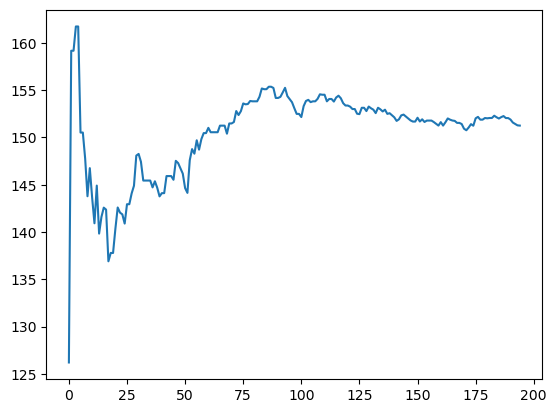

In [15]:
from model.normalizer import NormalizerXT
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt
from time_prediction_training import get_normalizer

normalizer_count = None
# val_set.set_random_patching(True)
xt_normalizer = NormalizerXT()
if 'normalize_channels' in opt['datasets'] and opt['datasets']['normalize_channels'] is True:
    pass
else:
    if evaluate_test_data:
        xt_normalizer,data_mean_arr, data_std_arr = get_normalizer(val_set, opt, return_data_arr=True, num_pixels=500_000 * 128 * 128)
    else:
        xt_normalizer,data_mean_arr, data_std_arr = get_normalizer(train_set, opt, return_data_arr=True)
    # val_set.reset_fixed_t()
    # val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0)
    # data_mean_arr = []
    # data_std_arr = []
    # normalizer_count = 100_000
    # cnt = 0
    # for _ in tqdm(range(normalizer_count)):
    #     bar = enumerate(val_loader)
    #     for i, (x, t_float) in bar:
    #         x = x.cuda()
    #         t_float = t_float.cuda()
    #         x = xt_normalizer.normalize(x,t_float, update=True)
    #         cnt += 1
    #         if cnt %10 == 0:
    #             data_mean_arr.append(xt_normalizer.data_mean.cpu().numpy())
    #             data_std_arr.append(xt_normalizer.data_std.cpu().numpy())

    plt.plot(np.stack(data_mean_arr)[:,90])
    del data_std_arr
    del data_mean_arr
    import gc; gc.collect()
# val_set.set_random_patching(False)

In [19]:
from tqdm import tqdm
import numpy as np
from core.time_estimation import TimeEstimator
from collections import defaultdict
from disentangle.core.tiff_reader import load_tiff
def get_unmixed_channels(pred_dir, mixing_t):
    bt_removed_pred = load_tiff(os.path.join(pred_dir, 'bt_removed_pred.tif'))
    dim_pred = load_tiff(os.path.join(pred_dir, 'dim_pred.tif'))
    if mixing_t >= 0.5:
        output_ch1 =  bt_removed_pred[...,0]
        output_ch2 = dim_pred[...,1]
    else:
        output_ch1 = dim_pred[...,0]
        output_ch2 = bt_removed_pred[...,1]
    return output_ch1, output_ch2

# num_timesteps = 10
num_timesteps = 10
gt = np.arange(0,1.0001,1/num_timesteps)
mmse_count = 1

pred_arr = []
inp_arr = []
# unmixed_ch1 = np.stack(val_set._data_dict[0])*1.0
# unmixed_ch2 = np.stack(val_set._data_dict[1])*1.0
# pred_dir_schema = '/group/GROUPNAMEUSERNAME/indiSplit/predictions/2502_HT_LIF24-joint_indi-l1_60/
pred_dir_schema = f'/group/GROUPNAMEUSERNAME/indiSplit/predictions/{indisplit_unmixing_dir}/'
pred_dir_schema = os.path.join(pred_dir_schema, 'T-{mixing_t}_MMSE-10_InferT-0_InferTAgg-0_FixedT-0.5/')
t_estimations = {}
with torch.no_grad():
    for mixing_t in tqdm(gt):
        if use_gt_as_unmixing_estimates:
            unmixed_ch1 = np.stack(val_set._data_dict[0])*1.0
            unmixed_ch2 = np.stack(val_set._data_dict[1])*1.0
        else:
            pred_dir  = pred_dir_schema.format(mixing_t=round(min(max(0.1,min(mixing_t, 1-mixing_t)),0.9),2))
            unmixed_ch1, unmixed_ch2 = get_unmixed_channels(pred_dir, mixing_t)

        t_estimations[mixing_t] = defaultdict(list)
        val_set.set_fixed_t(mixing_t)
        estimator = TimeEstimator()
        pred_t_arr = estimator.predict(val_set, xt_normalizer, model, mmse_count, return_input=False)
        estimator.set_agg_params(agg_mode='mean')
        t_estimations[mixing_t]['mean'].append(estimator.aggregate(pred_t_arr, val_set, unmixed_ch1, unmixed_ch2))
        estimator.set_agg_params(agg_mode='median')
        t_estimations[mixing_t]['median'].append(estimator.aggregate(pred_t_arr, val_set, unmixed_ch1, unmixed_ch2))
        estimator.set_agg_params(agg_mode='mode')
        t_estimations[mixing_t]['mode'].append(estimator.aggregate(pred_t_arr, val_set, unmixed_ch1, unmixed_ch2))
        estimator.set_agg_params(agg_mode='weighted_by_sum')
        t_estimations[mixing_t]['weighted_by_sum'].append(estimator.aggregate(pred_t_arr, val_set, unmixed_ch1, unmixed_ch2))
        estimator.set_agg_params(agg_mode='weighted_by_product')
        t_estimations[mixing_t]['weighted_by_product'].append(estimator.aggregate(pred_t_arr, val_set, unmixed_ch1, unmixed_ch2))

        # dloader = torch.utils.data.DataLoader(
        #             val_set,
        #             batch_size=16,
        #             shuffle=False,
        #             num_workers=2,
        #             pin_memory=True)
        # for data in dloader:
        #     inp, t_float = data
        #     assert torch.std(t_float) < 1e-6, f'{t_float}'
        #     assert t_float[0] == mixing_t, f'{t_float} != {mixing_t}'
        #     inp = inp.cuda()
        #     t_float = t_float.cuda()
        #     # if xt_normalizer is dummy then nothing will happen with the following operation.
        #     inp = xt_normalizer.normalize(inp, t_float)
        #     inp_arr.append(inp.cpu().numpy())
        #     tmp_pred_arr = []
        #     for _ in range(mmse_count):
        #         with torch.no_grad():
        #             pred = model(inp.cuda())
        #             tmp_pred_arr.append(pred.cpu().numpy())
        #     pred_arr.append(np.median(np.stack(tmp_pred_arr),axis=0))
    
    # all_pred = np.concatenate(pred_arr).reshape(len(gt),-1)
    # inp_arr = np.concatenate(inp_arr,axis=0)


  0%|          | 0/11 [00:00<?, ?it/s]

[96, 900, 1400, 1]
[96, 900, 1400, 1]


  9%|▉         | 1/11 [02:44<27:28, 164.81s/it]

[96, 900, 1400, 1]
[96, 900, 1400, 1]


 18%|█▊        | 2/11 [05:28<24:39, 164.34s/it]

[96, 900, 1400, 1]
[96, 900, 1400, 1]


 27%|██▋       | 3/11 [08:12<21:52, 164.04s/it]

[96, 900, 1400, 1]
[96, 900, 1400, 1]


 36%|███▋      | 4/11 [10:55<19:06, 163.82s/it]

[96, 900, 1400, 1]
[96, 900, 1400, 1]


 45%|████▌     | 5/11 [13:39<16:22, 163.71s/it]

[96, 900, 1400, 1]
[96, 900, 1400, 1]


 55%|█████▍    | 6/11 [16:22<13:37, 163.58s/it]

[96, 900, 1400, 1]
[96, 900, 1400, 1]


 64%|██████▎   | 7/11 [19:05<10:53, 163.38s/it]

[96, 900, 1400, 1]
[96, 900, 1400, 1]


 73%|███████▎  | 8/11 [21:49<08:10, 163.36s/it]

[96, 900, 1400, 1]
[96, 900, 1400, 1]


 82%|████████▏ | 9/11 [24:32<05:26, 163.38s/it]

[96, 900, 1400, 1]
[96, 900, 1400, 1]


 91%|█████████ | 10/11 [27:15<02:43, 163.37s/it]

[96, 900, 1400, 1]
[96, 900, 1400, 1]


100%|██████████| 11/11 [29:59<00:00, 163.55s/it]


In [20]:
mean_preds = []
median_preds = []
mode_preds = []
weighted_by_sum_preds = []
weighted_by_product_preds = []

for t in gt:
    mean_preds.append(t_estimations[t]['mean'][0])
    median_preds.append(t_estimations[t]['median'][0])
    mode_preds.append(t_estimations[t]['mode'][0])
    weighted_by_sum_preds.append(t_estimations[t]['weighted_by_sum'][0])
    weighted_by_product_preds.append(t_estimations[t]['weighted_by_product'][0])

def print_arr(arr):
    return ' '.join([f'{x:.2f}' for x in arr])

print(ckpt)
print('GT:\t\t\t', print_arr(gt))
print('Mean:\t\t\t', print_arr(mean_preds))
print('Median\t\t\t', print_arr(median_preds))
print('Mode\t\t\t', print_arr(mode_preds))
print('Weighted by Sum\t\t', print_arr(weighted_by_sum_preds))
print('Weighted by product\t', print_arr(weighted_by_product_preds))

/group/GROUPNAMEUSERNAME/training/diffsplit/2502/COSEM_jrc-hela-UnetClassifier-l2/14
GT:			 0.00 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.90 1.00
Mean:			 0.12 0.19 0.35 0.54 0.59 0.61 0.62 0.63 0.66 0.63 0.67
Median			 0.11 0.18 0.35 0.60 0.67 0.64 0.60 0.62 0.64 0.62 0.66
Mode			 0.10 0.17 0.15 0.76 0.71 0.66 0.58 0.60 0.63 0.60 0.66
Weighted by Sum		 0.13 0.15 0.22 0.33 0.44 0.56 0.65 0.67 0.66 0.64 0.64
Weighted by product	 0.14 0.16 0.23 0.34 0.45 0.58 0.67 0.70 0.68 0.66 0.65
